# PROJEKT DNO OKA - WERSJA NA 3
#### Jakub Stefański 151876
#### Filip Rosiak 151799


## Import potrzebnych bibliotek

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.metrics import sensitivity_score, specificity_score
import seaborn as sns

## Ścieżki zawierające analizowane zdjęcia

In [2]:
data_path = "data/"
hand_masks_path = "hand_masks/"

## Zaimplementowane funkcje 

Funkcja preprocess_image() służy do wstępnego przetworzenia obrazu. W pierwszym kroku obraz jest skalowany do mniejszego rozmiaru (1/9 oryginału), aby przyspieszyć przetwarzanie. Nastepnie wybierany jest kanał zielony z obrazu. W kolejnym kroku obraz kolorowy i zielony są filtrowane przy użyciu medianBlur() w celu wstępnego pozbycia się szumów i zakłóceń. Na koniec histogram kanału zielonego jest wyrównywany przy pomocy metody clahe, której użyliśmy zamiast equalizeHist(), który dodawał dużo szumu pokazującego się po zastosowaniu filtru Frangiego.

Funkcja preprocess_mask() służy do przeskalowania ręcznej maski. Oryginalna maska skalowana jest do rozmiaru 1/9 oryginału, a następnie przy pomocy threshold usuwamy odcienie szarości aby piksele maski były jednynie czarne oraz białe.

In [3]:
def preprocess_image(img):
    img = cv2.resize(img, (img.shape[1]//3, img.shape[0]//3))
    green_img = img[:,:,1]
    denoised_green_img = cv2.medianBlur(green_img, 5)
    denoised_img = cv2.medianBlur(img, 5)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    normalized_green_img = clahe.apply(denoised_green_img)

    return green_img, denoised_green_img, normalized_green_img, denoised_img


def preprocess_mask(mask):
    mask = cv2.resize(mask, (mask.shape[1]//3, mask.shape[0]//3))
    
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    return mask

Funkcja show_input() służy do wyświetlenia obrazu oraz jego maski przy pomocy biblioteki matplotlib. Przed wyświetleniem obraz przekształcany jest z przestrzeni barw BGR na RGB za pomocą funkcji cvtColor().

In [4]:
def show_input(file):
    img = cv2.imread(data_path+file)
    _, _, _, denoised_img = preprocess_image(img)

    mask_name = file[:-3]+"tif"
    mask = cv2.imread(hand_masks_path+mask_name, 0)
    mask = preprocess_mask(mask)
            
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.title(f"Input image {file}")
    plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB), cmap="gray")

    fig.add_subplot(122)
    plt.title(f"Hand-labeled mask {mask_name}")
    plt.imshow(mask, cmap="gray")

Funckja show_channels() służy do wyświetlenia oryginalnego obrazu oraz każdego z kanału kolorów. 

In [5]:
def show_channels(file):
    img = cv2.imread(data_path+file)
    _, _, _, img = preprocess_image(img)
    img2show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    blue_img = img[:,:,0]
    green_img = img[:,:,1]
    red_img = img[:,:,2]

    fig = plt.figure(figsize=(15,10))

    fig.add_subplot(141)
    plt.title(f"Original image {file}")
    plt.imshow(img2show, cmap="gray")

    fig.add_subplot(142)
    plt.title(f"Blue channel of {file}")
    plt.imshow(blue_img, cmap="gray")

    fig.add_subplot(144)
    plt.title(f"Green channel of {file}")
    plt.imshow(green_img, cmap="gray")

    fig.add_subplot(143)
    plt.title(f"Red channel of {file}")
    plt.imshow(red_img, cmap="gray")

Funckja show_normalization() wyświetla kanał zielony z jego histogramem przed oraz po normalizacji histogramu.

In [6]:
def show_normalization(original_green_img, normalized_green_img):
    fig = plt.figure(figsize=(12,8))
    fig.add_subplot(221)
    plt.title(f"Original green channel")
    plt.imshow(original_green_img, cmap="gray")

    fig.add_subplot(222)
    plt.title(f"Original green channel histogram")
    plt.hist(original_green_img.ravel(), bins=256, range=[0,256]);

    fig.add_subplot(223)
    plt.title(f"Normalized green channel")
    plt.imshow(normalized_green_img, cmap="gray")

    fig.add_subplot(224)
    plt.title(f"Normalized green channel histogram")
    plt.hist(normalized_green_img.ravel(), bins=256, range=[0,256]);

Funkcja process_image() wykonuje filtr Frangiego na zadanym obrazie, następnie obraz jest normalizowany do wartości miedzy 0 a 255. Na koniec wartości większe od 0 zmieniane są na 255.

Funckja show_process_image() wyświetla etapy obrazu z funcji process_iamge().

In [7]:
def process_image(normalized_green_img):
    frangi_img = frangi(normalized_green_img)
    normalized_frangi_img = cv2.normalize(frangi_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    enchanced_normalized_frangi_img = normalized_frangi_img.copy()
    enchanced_normalized_frangi_img[enchanced_normalized_frangi_img > 0] = 255


    return frangi_img, normalized_frangi_img, enchanced_normalized_frangi_img


def show_process_image(frangi_img, normalized_frangi_img, enchanced_normalized_frangi_img):
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(131)
    plt.title(f"Frangi filter")
    plt.imshow(frangi_img, cmap="gray")

    fig.add_subplot(132)
    plt.title(f"Frangi filter normalized")
    plt.imshow(normalized_frangi_img, cmap="gray")

    fig.add_subplot(133)
    plt.title(f"Frangi filter normalized and enchanced")
    plt.imshow(enchanced_normalized_frangi_img, cmap="gray")

Funkcja create_noise_mask() służy do tworzenia maski szumów obrazu. Funkcja rozpoczyna od stworzenia maski szumów o wymiarach takich samych jak obraz wejściowy oraz ustawia wartość wszystkich komórek na 255 zamiast 1 co będzie kluczowe dla poprawnego działania następnej funkcji. Następnie za pomocą funkcji findContours, znajdowane są wszystkie kontury na obrazie, po czym są filtrowane w taki sposób, aby zachować jedynie kontury których powierzchnia jest większa niż 150 pikseli. Na koniec interujemy po każdym konturze i wypełniamy go czarnym kolorem.

In [8]:
def create_noise_mask(enchanced_normalized_frangi_img):
    noise_mask = np.ones_like(enchanced_normalized_frangi_img)
    noise_mask[noise_mask > 0] = 255

    contours, _ = cv2.findContours(enchanced_normalized_frangi_img.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if cv2.contourArea(c) < 150]
    for contour in contours:
        cv2.drawContours(noise_mask, [contour], -1, 0, -1)
    
    return noise_mask

Funkcja get_vessels() służy do wyodrębnienia naczyń krwionośnych z obrazu za pomocą maski szumów. Działa poprzez zastosowanie oberacji bitowej AND między obrazem a maską szumów.

Funkcja compare_vessels() wyświetla stworzoną maskę naczyń razem z ręcznie stworzoną maską.

In [9]:
def get_vessels(enchanced_normalized_frangi_img, noise_mask):
    extracted_vessels = cv2.bitwise_and(enchanced_normalized_frangi_img, noise_mask)

    return extracted_vessels


def compare_vessels(extracted_vessles, mask):
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.title(f"Predicted vessles image")
    plt.imshow(extracted_vessles, cmap="gray")

    fig.add_subplot(122)
    plt.title(f"Hand-labeled image")
    plt.imshow(mask, cmap="gray")

Funkcja postprocess_image() wykonuje operacje morfologiczne na obrazie w celu poprawy jego jakości. Działa on przeprzez rozmycie i erozję obrazu co pomaga w wypełnianiu wnętrza naczyń.

In [10]:
def postprocess_image(extracted_vessles):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_img = cv2.dilate(extracted_vessles, kernel, iterations=3)
    filled_img = cv2.erode(dilated_img, kernel, iterations=2)

    return dilated_img, filled_img

Funkcja remove_circle() przy pomocy transformacji Hougha usuwa okrąg powstały przez użycie filtru Frangiego. Główna pętla funkcji trwa dopóki nie zostanie wykryty jeden okrąg lub żaden. Po wykrysiu okręgu zostaje on narysowany na dodatkowej masce. Następnie maska ta jest odejmowana od obrazu co skutkuje usunięciem okręgu. Na koniec piksele mające wartość mniejszą niż 255 ustawiane są na 0.

In [11]:
def remove_circle(filled_img):
    no_circle_img = filled_img.copy()
    circle = np.zeros_like(filled_img, np.uint8)
    offset = 0
    detections = []
    
    while True:
        detections = cv2.HoughCircles(no_circle_img, cv2.HOUGH_GRADIENT, 1.5, 600 + offset, minRadius=200)
        
        if detections is None or len(detections[0]) == 1:
            break

        offset += 50

    if detections is not None:
        x, y, r = detections[0][0]
        cv2.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), thickness=15)
    
    no_circle_img = no_circle_img - circle
    no_circle_img[no_circle_img < 255] = 0

    return no_circle_img

Funckja compare_masks() porównuje stworzoną maskę naczyć z maską ekspercką. Fukcja obliczna metryki takie jak trafność, czułość, swoistość oraz średnie arytmetyczne oraz geometryczne czułości i swoistości. Wyświetlana jest także macierz pomyłek. 

In [12]:
def compare_masks(original_mask, pred_mask):
    cm = confusion_matrix(original_mask.flatten(), pred_mask.flatten())

    acc = accuracy_score(original_mask.flatten(), pred_mask.flatten())
    sens = sensitivity_score(original_mask.flatten(), pred_mask.flatten(), pos_label=255)
    spec = specificity_score(original_mask.flatten(), pred_mask.flatten(), pos_label=255)

    print("Accuracy: ", acc)
    print("Sensitivity: ", sens)
    print("Specificity: ", spec)
    print("Mean of Sensitivity and Specificity: ", (sens+spec)/2)
    print("Geo mean of Sensitivity and Specificity: ", (sens*spec)**(1.0/2))

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Wywołanie funkcji

Poniższy kod uruchamia poszczególne funkcje,a by utworzyć maskę naczyń w oku.  
test_files - nazwy obrazów do przetworzenia.  
show_all - czy wyświetlić poszczególne etapy wszystkich obrazów, jeśli False, wyświetli szczegóły etapów przetwarzania tylko dla pierwszego obrazu.

11_h.jpg


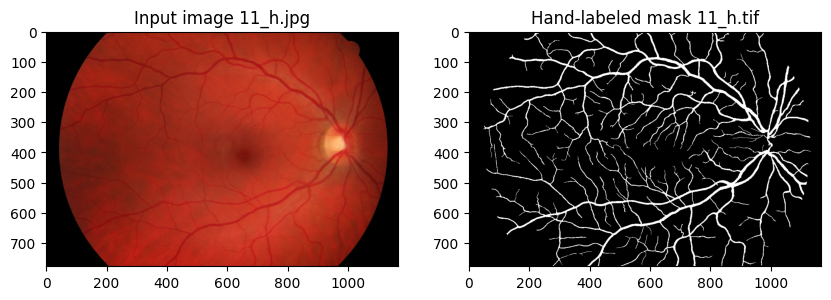

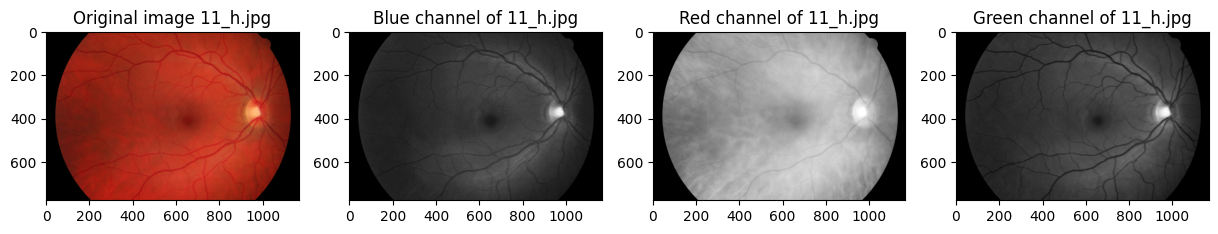

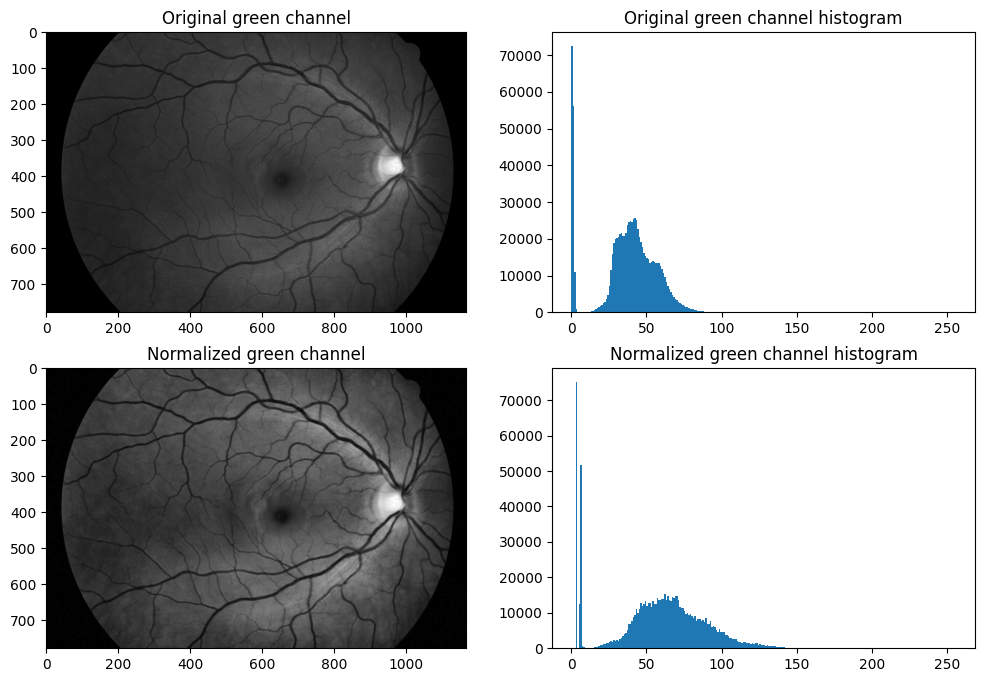

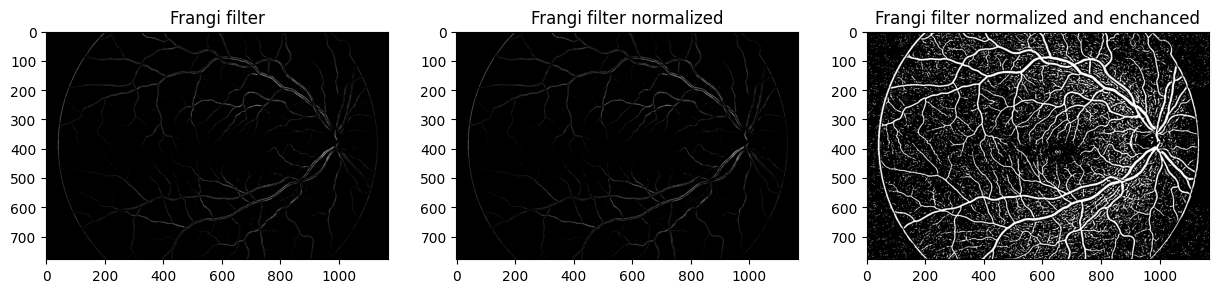

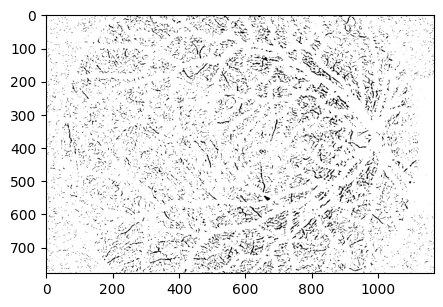

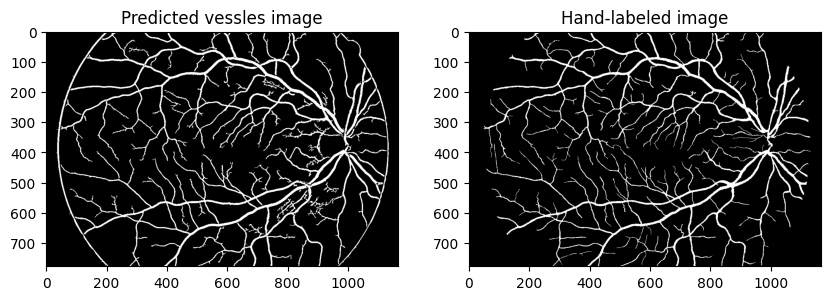

Accuracy:  0.9639728668521322
Sensitivity:  0.8602716188862214
Specificity:  0.9746701597121394
Mean of Sensitivity and Specificity:  0.9174708892991804
Geo mean of Sensitivity and Specificity:  0.9156861231752145


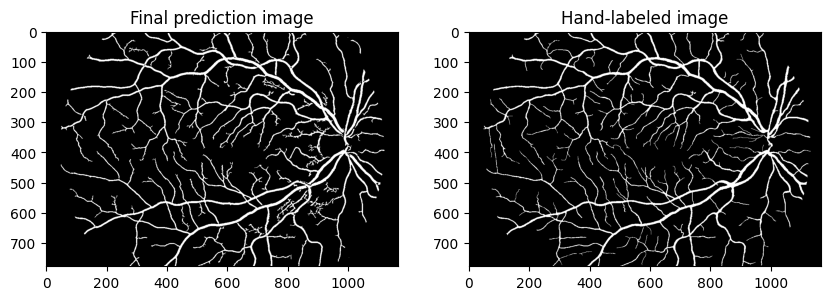

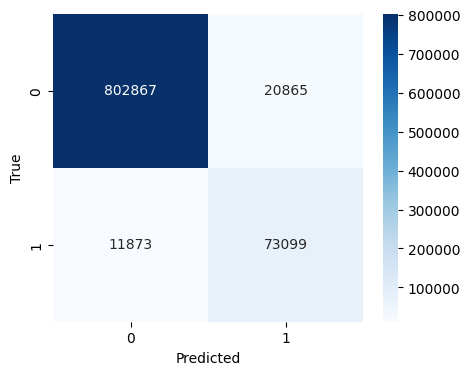

12_h.jpg
Accuracy:  0.9616332711201887
Sensitivity:  0.8538178463215944
Specificity:  0.9742771322094665
Mean of Sensitivity and Specificity:  0.9140474892655305
Geo mean of Sensitivity and Specificity:  0.9120609643787339


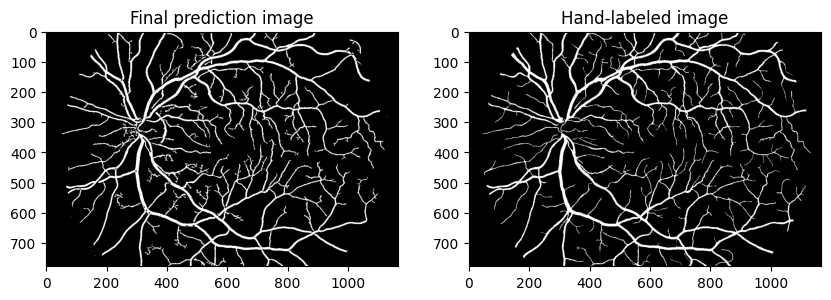

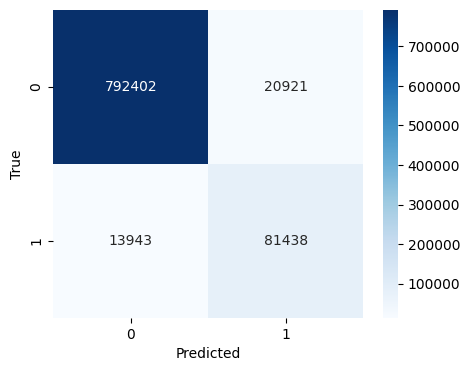

13_h.jpg
Accuracy:  0.9461012606965524
Sensitivity:  0.848256218748022
Specificity:  0.9554168991779045
Mean of Sensitivity and Specificity:  0.9018365589629633
Geo mean of Sensitivity and Specificity:  0.9002434816340574


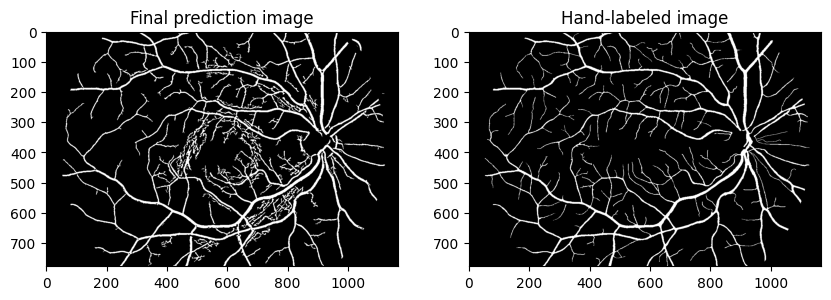

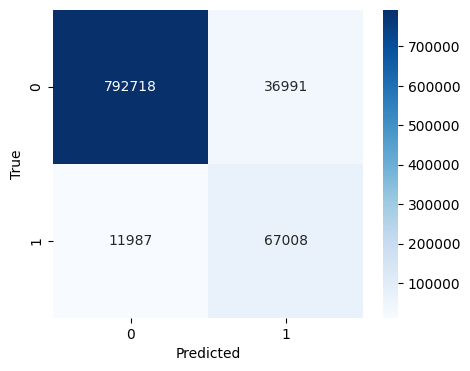

14_h.jpg
Accuracy:  0.9334766876782759
Sensitivity:  0.8667717130971889
Specificity:  0.9398570488103075
Mean of Sensitivity and Specificity:  0.9033143809537483
Geo mean of Sensitivity and Specificity:  0.9025749299995977


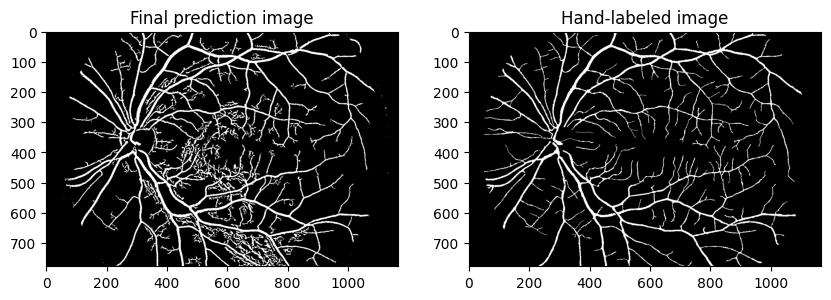

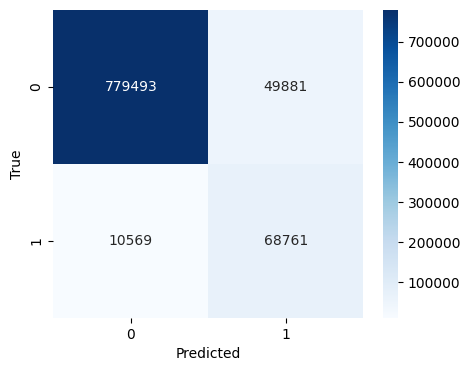

15_h.jpg
Accuracy:  0.9641214300806423
Sensitivity:  0.852378947368421
Specificity:  0.9736284022764236
Mean of Sensitivity and Specificity:  0.9130036748224223
Geo mean of Sensitivity and Specificity:  0.9109886676904249


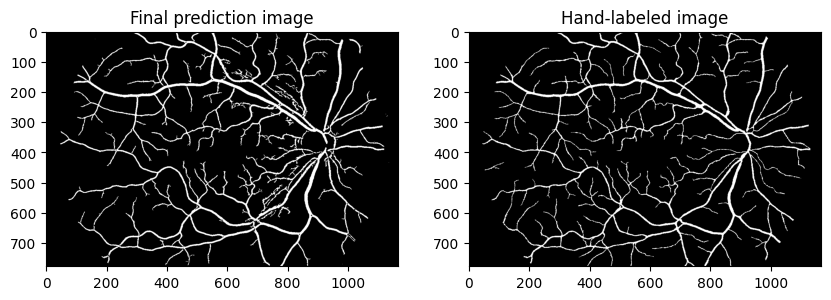

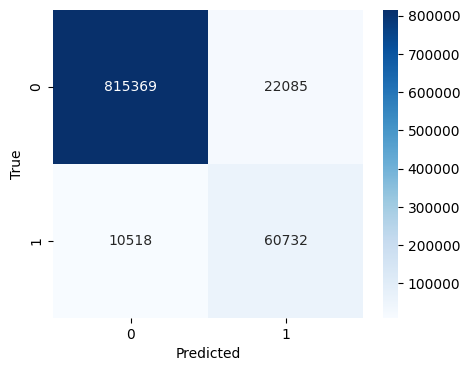

In [13]:
test_files = ["11_h.jpg", "12_h.jpg", "13_h.jpg", "14_h.jpg", "15_h.jpg"]
show_all = False

if show_all:
    files2show = test_files.copy()
    test_files.clear()
else:
    files2show = test_files[0:1]
    test_files = test_files[1:]

for file in files2show:
    print(file)
    show_input(file)
    show_channels(file)

    img = cv2.imread(data_path+file)
    green_img, _, normalized_green_img, original_img = preprocess_image(img)
    show_normalization(green_img, normalized_green_img)

    frangi_img, normalized_frangi_img, enchanced_normalized_frangi_img = process_image(normalized_green_img)

    show_process_image(frangi_img, normalized_frangi_img, enchanced_normalized_frangi_img)

        
    noise_mask = create_noise_mask(enchanced_normalized_frangi_img)
    fig = plt.figure(figsize=(5,5))
    plt.imshow(noise_mask, cmap='gray')

    extracted_vessles = get_vessels(enchanced_normalized_frangi_img, noise_mask)
    
    mask_name = file[:-3]+"tif"
    mask = cv2.imread(hand_masks_path+mask_name, 0)
    mask = preprocess_mask(mask)

    compare_vessels(extracted_vessles, mask)

    _, filled_img = postprocess_image(extracted_vessles)

    no_circle_img = remove_circle(extracted_vessles)
    
    plt.show()
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.title(f"Final prediction image")
    plt.imshow(no_circle_img, cmap="gray")

    fig.add_subplot(122)
    plt.title(f"Hand-labeled image")
    plt.imshow(mask, cmap="gray")

    compare_masks(mask, no_circle_img)

for file in test_files:
    print(file)

    img = cv2.imread(data_path+file)
    green_img, _, normalized_green_img, original_img = preprocess_image(img)

    frangi_img, normalized_frangi_img, enchanced_normalized_frangi_img = process_image(normalized_green_img)
        
    noise_mask = create_noise_mask(enchanced_normalized_frangi_img)

    extracted_vessles = get_vessels(enchanced_normalized_frangi_img, noise_mask)
    
    mask_name = file[:-3]+"tif"
    mask = cv2.imread(hand_masks_path+mask_name, 0)
    mask = preprocess_mask(mask)

    _, filled_img = postprocess_image(extracted_vessles)

    no_circle_img = remove_circle(extracted_vessles)
    
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(121)
    plt.title(f"Final prediction image")
    plt.imshow(no_circle_img, cmap="gray")

    fig.add_subplot(122)
    plt.title(f"Hand-labeled image")
    plt.imshow(mask, cmap="gray")

    compare_masks(mask, no_circle_img)